In [502]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter, defaultdict
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import re
import regex
import spacy
import emoji
%matplotlib inline

In [679]:
blackpink = pd.read_csv('more.csv', lineterminator='\n')

In [1370]:
unique_comments = Counter(blackpink['Comment'])

In [1372]:
blackpink.shape

(14703, 10)

In [ ]:
unique_langs = Counter(blackpink['Expanded Language Name'])
truncated_langs = {key: unique_langs[key] for key in unique_langs if (unique_langs[key] > 20 and
                                                                     key != 'Emoji' and
                                                                     key != 'English')}
truncated_langs_pd = pd.DataFrame.from_dict(truncated_langs.items())
truncated_langs_pd.columns = ["Language", "Count"]
truncated_langs_pd = truncated_langs_pd.dropna()
truncated_langs_pd.sort_values("Count")

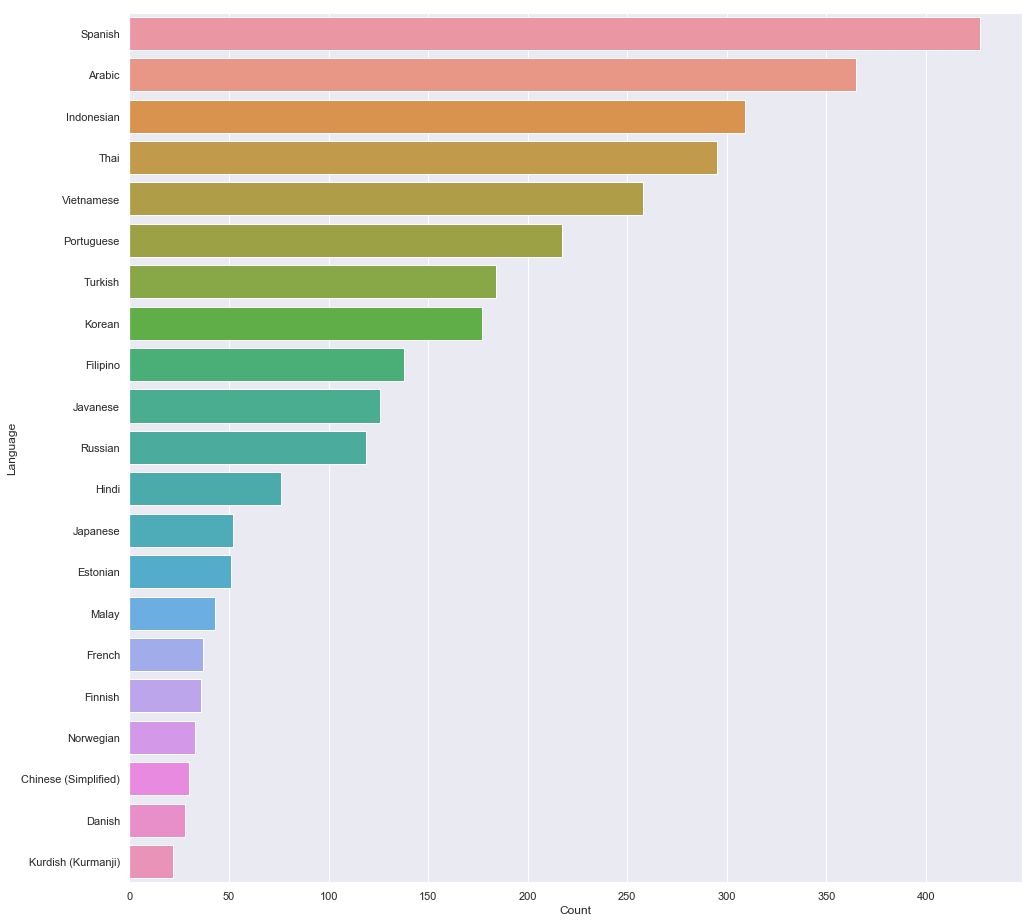

In [682]:
plt.figure(figsize=(16, 16))
sns.barplot(y="Language", x="Count", data=truncated_langs_pd.sort_values("Count", ascending=False))



# Now let's do some sentiment analysis of the four members

We'll be using VADER Sentiment for this task. First, let's separate our comments to ones that contain only one of each member. What I have is a little long, so if you have any suggestions, please bring them up!

In [1351]:
only_jennie = blackpink['Comment'].str.contains("jennie|제니", case=False) & \
~blackpink['Comment'].str.contains("rosé|rose|lisa|jisoo|로제|지수|리사", case=False)

only_jisoo = blackpink['Comment'].str.contains("jisoo|지수", case=False) & \
~blackpink['Comment'].str.contains("rosé|rose|lisa|jennie|로제|제니|리사", case=False)

only_rose = blackpink['Comment'].str.contains("rose|로제", case=False) & \
~blackpink['Comment'].str.contains("jennie|lisa|jisoo|지수|제니|리사", case=False)

only_lisa = blackpink['Comment'].str.contains("lisa|리사", case=False) & \
~blackpink['Comment'].str.contains("rosé|rose|jennie|jisoo|지수|제니|로제", case=False)


In [1352]:
print(blackpink[only_jennie].shape, 
      blackpink[only_jisoo].shape, 
      blackpink[only_rose].shape, 
      blackpink[only_lisa].shape, 
      blackpink.shape)

(257, 10) (258, 10) (126, 10) (551, 10) (14703, 10)


Jennie and Jisoo are almost tied in the comments that relate to only them. Lisa has the most comments, and Rose has the least comments about her. It would be interesting to see the distribution of sentiment about each of them, and what topics are relevant to each person. 

Let's find the comments that are originally in English. After working through this, we can then select other languages and apply the same analysis.

In [1353]:
def get_results_of_comparison(target_value, source_column, target_column, dataset):
    # create a boolean mask
    mask = dataset[source_column].values == target_value
    pos = np.flatnonzero(mask) # get idx
    return mask, pos, dataset[mask][target_column]


In [1354]:
mask, pos, jennie_english = get_results_of_comparison("English", "Expanded Language Name",
                                                     "Comment", blackpink[only_jennie])
mask, pos, jisoo_english = get_results_of_comparison("English", "Expanded Language Name",
                                                     "Comment", blackpink[only_jisoo])

mask, pos, rose_english = get_results_of_comparison("English", "Expanded Language Name",
                                                     "Comment", blackpink[only_rose])

mask, pos, lisa_english = get_results_of_comparison("English", "Expanded Language Name",
                                                     "Comment", blackpink[only_lisa])

In [1355]:
print(len(jennie_english),
      len(jisoo_english),
      len(rose_english), 
      len(lisa_english) )  

print("percentage of english comments for Jennie:", len(jennie_english) / len(blackpink[only_jennie]))
print("percentage of english comments for Jisoo:", len(jisoo_english)  / len(blackpink[only_jisoo]))
print("percentage of english comments for Rose:", len(rose_english)   / len(blackpink[only_rose]))
print("percentage of english comments for Lisa:", len(lisa_english)   / len(blackpink[only_lisa]))

207 133 105 375
percentage of english comments for Jennie: 0.8054474708171206
percentage of english comments for Jisoo: 0.5155038759689923
percentage of english comments for Rose: 0.8333333333333334
percentage of english comments for Lisa: 0.6805807622504537


Could it be that Jennie and Rose are more popular among English speakers?


In [1356]:
analyzer = SentimentIntensityAnalyzer()

# Text Preprocessing

In [1357]:
def strip_symbols(text):
    words = text.split()
    
    # https://stackoverflow.com/questions/58833864/python-regex-removing-all-special-characters-and-numbers-not-attached-to-words
    return ' '.join(re.findall(r'(?:[^\W\d_]+\d|\d+[^\W\d_])[^\W_]*|[^\W\d_]+', text))

In [1358]:
def keep_emojis_strip_symbols(text):
    stripped = []
    
    text_to_words = text.split()
    for word in text_to_words:
        data = regex.findall(r'\X', word)
        has_emoji = False
        the_emoji = []
        for char_combo in data:
            if any(char in emoji.UNICODE_EMOJI for char in char_combo):
                has_emoji = True
                break
            else:
                continue
                
        # after analyzing the characters of a word
        if has_emoji:
            stripped.append(''.join(word))
        else:
            stripped.append(strip_symbols(word))
    return ''.join(stripped)

In [1359]:
print(keep_emojis_strip_symbols("Omg,I love Jennie's hair in this so much"))

Omg IloveJennie shairinthissomuch


In [1360]:
cleaned_jennie_english = []

def clean_comments(document):
    cleaned = []
    for comment in nlp.pipe(document, disable=['parser']):
        sentence = [keep_emojis_strip_symbols(word.lemma_) \
                    if word.lemma_ != '-PRON-' else word.text \
                    for word in comment]
        cleaned.append(' '.join(sentence))
    return cleaned


cleaned_jennie_english = clean_comments(jennie_english)
cleaned_jennie_sentiment = [analyzer.polarity_scores(doc)['compound'] for doc in cleaned_jennie_english]
print(len(cleaned_jennie_english))
      
      

207


In [1361]:
# Manual review of sentiments post- and pre-processing
def compare_diffs(cleaned_comments, orig_comments, cleaned_sent, orig_sent, indices):
    agree = 0
    disagree = 0
    for i in indices:
        print(cleaned_sent[i], ":", orig_sent[i])
        print(cleaned_comments[i])
        print(orig_comments[i])
        print()
        if cleaned_sent[i] != orig_sent[i]:
            disagree += 1
        else:
            agree += 1
    print(agree, disagree)
    

In [1362]:
# success/ why cleaning is important
success = [1]
compare_diffs(cleaned_jennie_english, jennie_english.tolist(), 
              cleaned_jennie_sentiment, jennie_sentiment, success)

-0.8317 : 0.4184
 no one love JENNIE  JENNIE SUCKS  
*NO ONE LOVES JENNIE! JENNIE SUCKS!*

0 1


In [1363]:
# sometimes cleaning introduces its own difficulties
difficulties = [91]
compare_diffs(cleaned_jennie_english, jennie_english.tolist(), 
              cleaned_jennie_sentiment, jennie_sentiment, difficulties)
# inconsistencies: 96, 127, 124, 135

0.4404 : 0.6369
Jennie be the good
Jennie is the Best

0 1


The above is probably because of the word "best" changing to just "good".

## Understanding Compound Score
Positive sentiment generally is understood as having a compound score >= 0.05
Neutral is between -0.05 and 0.05
And negative is less than or equal to -0.05

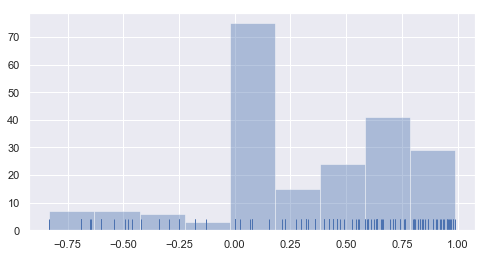

In [1364]:
plt.figure(figsize=(8, 4))
sns.distplot(cleaned_jennie_sentiment, rug=True, kde=False)


Let's create cleaned comments and ensuing sentiments for the rest of the members

In [1365]:
cleaned_jisoo_english = clean_comments(jisoo_english)
cleaned_jisoo_sentiment = [analyzer.polarity_scores(doc)['compound'] for doc in cleaned_jisoo_english]

cleaned_rose_english = clean_comments(rose_english)
cleaned_rose_sentiment = [analyzer.polarity_scores(comment)['compound'] for comment in cleaned_rose_english]

cleaned_lisa_english = clean_comments(lisa_english)
cleaned_lisa_sentiment = [analyzer.polarity_scores(comment)['compound'] for comment in cleaned_lisa_english]

[Text(0.5, 0, 'Lisa')]

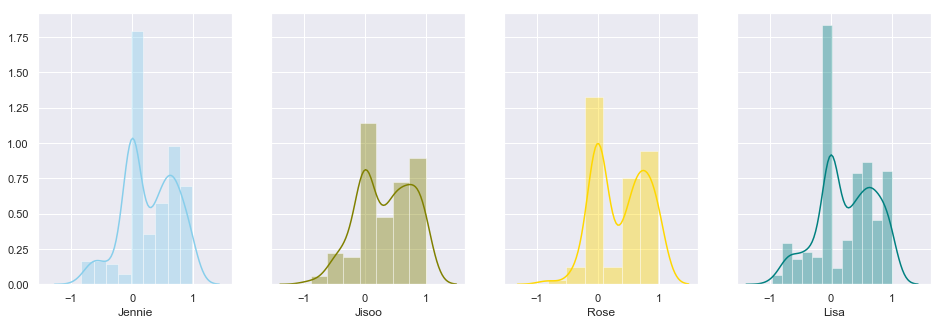

In [1366]:
f, axes = plt.subplots(1, 4, figsize=(16, 5), sharex=True, sharey=True)
sns.distplot(cleaned_jennie_sentiment , color="skyblue", ax=axes[0])
sns.distplot(cleaned_jisoo_sentiment, color="olive", ax=axes[1])
sns.distplot(cleaned_rose_sentiment , color="gold", ax=axes[2])
sns.distplot(cleaned_lisa_sentiment , color="teal", ax=axes[3])

axes[0].set(xlabel='Jennie')
axes[1].set(xlabel='Jisoo')
axes[2].set(xlabel='Rose')
axes[3].set(xlabel='Lisa')


We can see some interesting things from the histograms. Most of the members have relatively greater amounts of neutral comments than positive comments, and more positive comments than negative comments. This is interesting, because generally you'd expect YouTube comments on a music video to either be positive or negative. We can take a closer look at the neutral comments and see for ourselves whether the classifications make sense.

Jisoo has the closest proportion of neutral to positive comments, while other members see a more skewed ratio. It seems like Rose has mostly neutral or very positive comments, and that Lisa has more negative comments than the other members.

In [1368]:
for sentiment, comment in zip(cleaned_lisa_sentiment, lisa_english.tolist()):
    print(sentiment, comment)

0.2263 Jenlisa:Look you now look at me
Me:okay i get it
0.0 Lisa🤢🤢🤢🤢
0.1901 Lisa is literally Cleopatra here. 
Background around her, hawk, hair..  
She looks like Cleopatra but she is still a tai princess.
0.0 Lisa
0.0 QUEEN LISA
0.0 Lisa
0.0 I can't get enough of Lisa's parts
0.5719 Reason behind this video success:

Spot Lord *Ganesha Ji* at 1:20 at the left bottom beside Lisa.

Jai Sanatan Dharma
0.4019 Lets support lalisa download BRAWL STARS
0.6369 I love Lisa's hair colors
0.0 It's not a Blackpink song without Lisa's iconic: BLACKPINK IN YOUR AREA.
0.0 Lisaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa
0.0 Lisa is Cardi B .
0.0 TEAM LISAAAAA! #lookatchuuuunowlookatme
-0.6597 Lisa's raper
0.7068 Lisas rap and backing tune for it sounds so similar....like similar to daechwita

I think the vader sentiment library is understanding the "kill", "fire", and "🔥 😵 ⚡" words and emojis as negative rather than positive. However, there are some commentary that are correctly identified as negative, such as, "IS LISA'S A MOCK FOR INDIANS 😡😡😡😡😡😡😡😡😡😡😡😡😡😡😡😡😡😡😡😡😡😡😡😡😡😡", 
"Just remember haters!! Dont hate blackpink for this mistake. Hate the producers instead specially YG. Hehe", and 
"I think we seriously deserve at least an apology for the disrespect they showed to Ganesha. I get it that they wanted to remove obstacles or promote hinduism but keep him ON THE FLOOR ?! YOU CAN DO BETTER THAN THAT OKAY ? AND LISA WAS WEARING SHOES IN HIS FACE!! i'm am no toxic fan but let me tell you this what if they broke a jesus statue? or disrespected any other religion? i don't think that you can forgive them. i am an aethiest but i respect my culture and i wont stop until i get that apology, not by jyp but by the members themselves. help me. #bpapologise 
and if you dont like this stand up im telling you, you are a disgrace to your tradition and culture.

and it is not fair how they edited him out, and didnt say sorry. HOW RUDE !"


# Simple Extractive Text Summarization

To generate sentiment for the texts, we went through a standard NLP text preprocessing pipeline. We extracted alphanumeric characters from the original text, but we also kept emojis since our sentiment library is capable of handling them. We then lemmatized the alphanumeric characters, removing inflectional endings to return the base form of the word.

To do extractive text summarization, we'll use the fairly simple bag of words technique, and then tf-idf.

We'll divide each collection of comments into three sentiments, negative, neutral, and positive. 

Using sets from: https://towardsdatascience.com/natural-language-processing-feature-engineering-using-tf-idf-e8b9d00e7e76

In [1153]:
def split_pos_neg_neu(comments, sentiments):
    positive = [[index, comment_sentiment[0]] for index, comment_sentiment in \
               enumerate(zip(comments, sentiments)) \
               if comment_sentiment[1] >= 0.05]
    negative = [[index, comment_sentiment[0]] for index, comment_sentiment in \
               enumerate(zip(comments, sentiments)) \
               if comment_sentiment[1] <= -0.05]
    neutral = [[index, comment_sentiment[0]] for index, comment_sentiment in \
               enumerate(zip(comments, sentiments)) \
               if -.05 < comment_sentiment[1] < 0.05]
    return positive, negative, neutral

lisa_pos, lisa_neg, lisa_neu = split_pos_neg_neu(cleaned_lisa_english, 
                                                               cleaned_lisa_sentiment)
jisoo_pos, jisoo_neg, jisoo_neu = split_pos_neg_neu(cleaned_jisoo_english, 
                                                    cleaned_jisoo_sentiment)
rose_pos, rose_neg, rose_neu = split_pos_neg_neu(cleaned_rose_english, 
                                                 cleaned_rose_sentiment)
jennie_pos, jennie_neg, jennie_neu = split_pos_neg_neu(cleaned_jennie_english, 
                                                       cleaned_jennie_sentiment)



In [1154]:

print(len(lisa_pos), len(lisa_neg), len(lisa_neu))
print(len(jisoo_pos), len(jisoo_neg), len(jisoo_neu))
print(len(rose_pos), len(rose_neg), len(rose_neu))
print(len(jennie_pos), len(jennie_neg), len(jennie_neu))

203 63 109
80 18 35
58 5 42
114 23 70


It would make sense that the majority of comments would be positive, and sure enough, positive comments account for just a little over half of all comments specific to Lisa. To retrieve the original comment, we can index into our unprocessed, original comments.

In [1155]:
print(lisa_english.tolist()[lisa_neu[80][0]])
print(lisa_english.tolist()[lisa_pos[200][0]])
print(lisa_english.tolist()[lisa_neg[50][0]])

Is it just me or does the last few lines of Lisa's rap starting from 1:18 sound similar to Lisa's last few lines of her rap in Kick It??!!!!
I love lisa
Lisa is ugly


In [1156]:
# now mash all the words up into one list

stopwords = [word for word in list(STOP_WORDS) if 'no' not in word]
stopwords.extend(['ur', 'u'])

def get_freqs(**kwargs):
    """
    Given pos, neg, and neu splits, return freqs of each and total freq
    """
    positive_words = [word.lower() for index_comment in kwargs['pos'] \
                      for word in index_comment[1].split() \
                      if word not in stopwords]
    freq_positive_words = Counter(positive_words)
    negative_words = [word.lower() for index_comment in kwargs['neg'] \
                      for word in index_comment[1].split() \
                      if word not in stopwords]
    freq_negative_words = Counter(negative_words)
    neutral_words = [word.lower() for index_comment in kwargs['neu'] \
                     for word in index_comment[1].split() \
                     if word not in stopwords]
    freq_neutral_words = Counter(neutral_words)

    return freq_positive_words, freq_negative_words, freq_neutral_words

# Normalize by largest frequency

In [1157]:
# normalize term frequency by largest frequency per document
# relative frequency
def normalize_word_count(words):
    max_freq = max(words.values())
    return {key:value/max_freq for (key, value) in words.items()}

# freq_pos = pd.DataFrame.from_dict(normalize_word_count(freq_positive_words_no_sw, max_pos).items())
freq_pos = normalize_word_count(freq_positive_words_no_sw)
freq_neg = normalize_word_count(freq_negative_words_no_sw)
freq_neu = normalize_word_count(freq_neutral_words_no_sw)



# Calculate IDF
Which is the log of the number of documents divided by the number of documents that contain the word

In [1158]:
# calculate idf
def computeIDF(*args):
    """
    Given parameters of type dict, calculate idf
    """
    import math
    num_docs = 0
    idfs = {}
    for freq_dict in args:
        for word, freq in freq_dict.items():
            if idfs.get(word):
                idfs[word] += 1
            else:
                idfs[word] = 1
        num_docs += 1
    # normalize
    for word, doc_freq in idfs.items():
        idfs[word] = math.log(num_docs / doc_freq)
    return idfs

idf = computeIDF(freq_pos, freq_neg, freq_neu)

In [1159]:
# now calculate tf-idf for all words

def compute_tfidf(freqs, idfs):
    return {word:freq * idfs[word] for word, freq in freqs.items()}


In [1160]:
tfidf_pos = compute_tfidf(freq_pos, idf)
tfidf_neg = compute_tfidf(freq_neg, idf)
tfidf_neu = compute_tfidf(freq_neu, idf)

In [1202]:
# Put it altogether

def get_tfidf(comments, sentiments):
    pos, neg, neu = split_pos_neg_neu(comments, sentiments)

    freq_pos, freq_neg, freq_neu = get_freqs(pos=pos,
                                             neg=neg,
                                             neu=neu)
    
    freq_pos = normalize_word_count(freq_pos)
    freq_neg = normalize_word_count(freq_neg)
    freq_neu = normalize_word_count(freq_neu)
    
    idf = computeIDF(freq_pos, freq_neg, freq_neu)
    
    tfidf_pos = compute_tfidf(freq_pos, idf)
    tfidf_neg = compute_tfidf(freq_neg, idf)
    tfidf_neu = compute_tfidf(freq_neu, idf)
    
    return tfidf_pos, tfidf_neg, tfidf_neu, pos, neg, neu


In [1203]:
lisa_pos, lisa_neg, lisa_neu, lisa_pc, lisa_nc, lisa_neuc = get_tfidf(cleaned_lisa_english, cleaned_lisa_sentiment)


# Using TF-IDF

Now that we've obtained our tf-idf scores for each word, let's measure the sentence length

In [1319]:
# now that we've normalized word frequency, let's measure the sentence strength

def get_sent_strength_of_doc(doc, tfidf):
    from collections import defaultdict
    sent_strength = defaultdict(float)
    index = 0
    # for each sentence
    for sent in doc:
        # handle empty strings
        sent_length = len(sent) if len(sent) > 0 else 1
        
        for word in sent: 
            if word in tfidf.keys(): 
                    sent_strength[sent]+= tfidf[word]
        sent_strength[sent] /= sent_length
        index += 1
    return sent_strength

def get_sentences(comments):
    return [sentence \
            for index_comment in comments \
            for sentence in re.split(r'\s{2,}', index_comment[1])]

def get_comments(comments):
    return [index_comment[1] \
            for index_comment in comments]


In [1330]:
# jisoo_pos_comments = get_sentences(jisoo_pc)
lisa_neg_comments = get_comments(lisa_nc)

In [1331]:
from heapq import nlargest

In [1332]:
sent_strength = get_sent_strength_of_doc(lisa_neg_comments, lisa_neg)
summarized_sentences = nlargest(10, sent_strength, key=sent_strength.get)

In [1333]:
summarized_sentences

['be LISA S a mock for INDIANS 😡 😡 😡 😡 😡 😡 😡 😡 😡 😡 😡 😡 😡 😡 😡 😡 😡 😡 😡 😡 😡 😡 😡 😡 😡 😡',
 'G Dragon X Lisa 🔥 🔥 🔥 🔥',
 'LISA you KILLD IT 🔥 🔥 🔥',
 'Lisa be swag sooooooo hard 🌟 🌟 🌟',
 'Cleolisa 🔥',
 'Lisa I be right back 👑 🔥 🌟',
 'Lisa you be fire 🔥 😵 ⚡',
 'somebody notice the ganesh statue in near of the lisa in the mv iam realy sad of that 😞 😞 😞 😞 😠',
 'ugh  LISA MANOBAN s OVERFLOWING SWAAAAAAG  damn girl    🤯 🤯 🤯',
 'the ganesha case be just rise   why hate on bp   many people be hate on Lisa and Bp 😒 😒  I luv this song 🤩 😍 🤩 😍 🤩']

In [1348]:
analyzer.polarity_scores("OVERFLOWING SWAAAAAAG")

{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}

In [1265]:
lisa_pos_comments = get_sentences(lisa_positive)
lisa_neg_comments = get_sentences(lisa_negative)


jisoo_pos, jisoo_neg, jisoo_neu, jisoo_pc, jisoo_nc, jisoo_neuc = get_tfidf(cleaned_jisoo_english,
                                                                           cleaned_jisoo_sentiment)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
